In [153]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

In [155]:
df_raw = pd.read_excel("../data/raw/BASE DATOS CON CIE-10_Actualizada 25-07-2023.xls")

In [156]:
df = pd.read_csv("../data/processed/df_procesada.csv")

In [163]:
df["region"].value_counts()

region
Región Metropolitana de Santiago, Chile                    1487
Región Del Bíobío, Chile                                    235
Región Del Maule, Chile                                     231
Región De Coquimbo, Chile                                   222
Región del Libertador General Bernardo O'Higgins, Chile     178
Región De Valparaíso, Chile                                 161
Región De Los Lagos, Chile                                  152
Región De La Araucanía, Chile                                83
Región De Antofagasta, Chile                                 62
Región De Arica y Parinacota, Chile                          60
Región De Tarapacá, Chile                                    46
Región De Atacama, Chile                                     40
Región Aysén del General Carlos Ibáñez del Campo, Chile      38
Región De Magallanes y de La Antártica Chilena, Chile        31
Región De Los Ríos, Chile                                    20
Región De Ñuble, Chile           

In [165]:
# Eliminamos las filas que no tienen fecha de evaluación
df_limpia = df.dropna(subset="fecha_1_evaluacion").copy()
df_limpia = df_limpia.query("anio_1_evaluacion >= 2000")
df_limpia["fecha_1_evaluacion"] = pd.to_datetime(df_limpia["fecha_1_evaluacion"])
df_limpia["f_nac"] = pd.to_datetime(df_limpia["f_nac"])
df_limpia["edad_1_evaluacion_calc"] = (
    df_limpia["fecha_1_evaluacion"] - df_limpia["f_nac"]
).dt.days / 365

In [166]:
# Obtiene la cantidad de pacientes anuales
cantidad_de_pacientes = df_limpia.groupby("anio_1_evaluacion")["rut"].nunique()

# Obtiene la distribucion de la prevision a lo largo de los anios
prevision = df_limpia.groupby("anio_1_evaluacion")["prevision"].value_counts().unstack()
prevision.loc["Total", :] =  prevision.sum()

# Obtiene la distribucion de la 1era edad de consulta
edad_primera_consulta = df_limpia.groupby("anio_1_evaluacion")["edad_1_evaluacion_calc"].describe()

# Obtiene el desglose por region
desglose_por_region = df_limpia.groupby("anio_1_evaluacion")["region"].value_counts().unstack()

<Axes: xlabel='anio_1_evaluacion'>

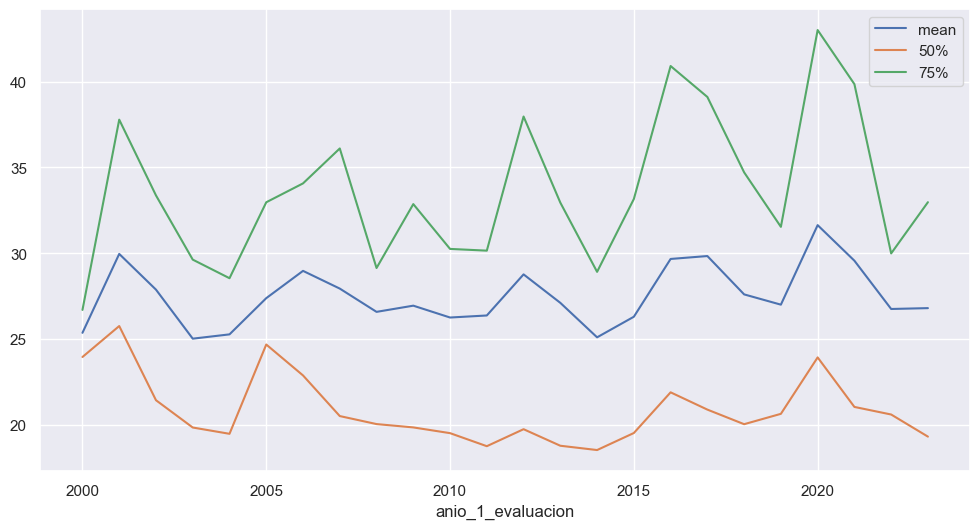

In [169]:
edad_primera_consulta[["mean", "50%", "75%"]].plot()

<Axes: xlabel='anio_1_evaluacion'>

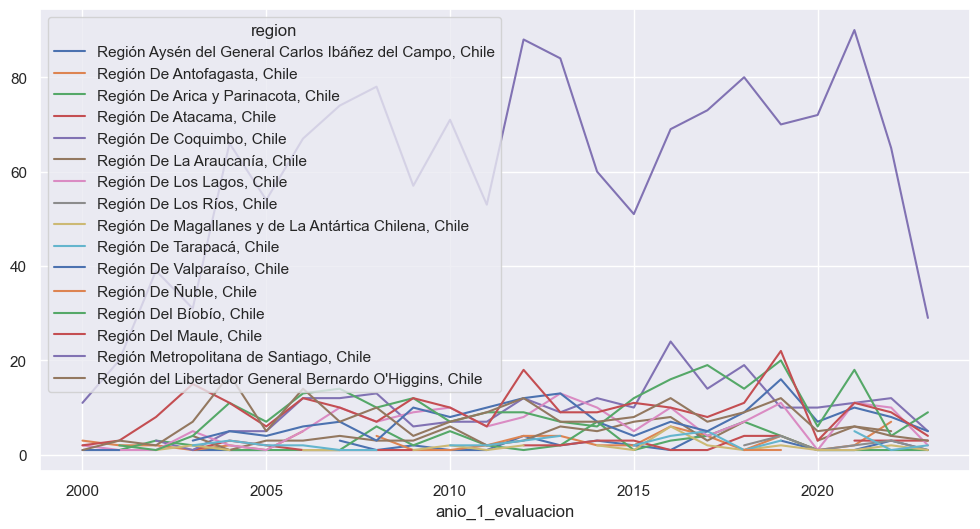

In [170]:
desglose_por_region.plot()